## Scenario 1: Analysing a series of initial rate data using Michaelis-Menten kinetics 

Dataset provided by Maria F. Pinto (Institute of Biomedical Sciences, University of Porto, 4050-313 Porto, Portugal).

This Jupyter Notebook accompanies the first scenario of the paper: EnzymeML at work: seamless data flow and modelling of enzymatic data. 
In this scenario, the time-course data from the EnzymeML document is estimated with a Michaelis-Menten model and later compared to the results from the modelling by the webserver of interferENZY. 

## Imports

Install and import all necessary Python packages.
In order to run on google Colaboratory (Colab), PyEnzyme will be installed and the dataset is loaded from GitHub. This is done in the first Code Cell.
To run the notebook on Colab click on the badge:
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EnzymeML/Lauterbach_2022/blob/main/Scenario1/AnalysingInitialRateDataUsingMichaelisMentenKineticsJupyterNotebook.ipynb)  
If you run this notebook local make sure you have all Packages installed and the dataset in the same directory as the notebook.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+git://github.com/EnzymeML/PyEnzyme.git@Refactoring
    !pip install lmfit
    !wget https://github.com/EnzymeML/Lauterbach_2022/raw/main/Scenario1/Desulfuration_Cysteine_Pinto.omex
else:
    print('Not running on Colab.')

Not running on Colab.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit

from pyenzyme import EnzymeMLDocument
from pyenzyme.enzymeml import DataTypes

## Read-in of the EnzymeML document

The chosen EnzymeML document is integrated into the workflow and a short overview of the dataset is printed out. 

In [3]:
path = 'Desulfuration_Cysteine_Pinto.omex'
# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLDocument.fromFile(path)
else:
    print('Incorrect file path.')

enzmlDoc.printDocument(measurements=True)

Pinto_Measurements (modelled by interferENZY)
>>> Reactants
	ID: s0 	 Name: L-cysteine
	ID: s1 	 Name: sulfide
	ID: s2 	 Name: L-alanine
>>> Proteins
	ID: p0 	 Name: Cysteine Desulfurase
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Cysteine desulfuration
>>> Measurements

ID   Species   Conc     Unit   
m0   p0        1      umole / l
m0   s0        500    umole / l
m0   s1        0      umole / l
m0   s2        0      umole / l
m1   p0        1      umole / l
m1   s0        100    umole / l
m1   s1        0      umole / l
m1   s2        0      umole / l
m2   p0        1      umole / l
m2   s0        50     umole / l
m2   s1        0      umole / l
m2   s2        0      umole / l
m3   p0        1      umole / l
m3   s0        25     umole / l
m3   s1        0      umole / l
m3   s2        0      umole / l
m4   p0        1      umole / l
m4   s0        10     umole / l
m4   s1        0      umole / l
m4   s2        0      umole / l
m5   p0        1      umole / l
m5   s0        5      um

## Preparation of the data

In a first step, all important information, including the initital concentrations and the time-course data, is extracted. In addition, variables and colours are defined for the subsequent visualisation. Chosen for the visualisation is the increase in sulfide concentration over the time

In [4]:
# Educts:
s0_init_conc = []
# Product:
s1_init_conc = []
s2_init_conc = []
measured_data = []
# Protein:
p0_init_conc = []

# time and units
measurement = enzmlDoc.getMeasurement("m0")
time = measurement.global_time
time_unit = measurement.global_time_unit
conc_unit = ''

# go through all measurements:
for measurement in enzmlDoc.measurement_dict.values():
    
    # get replicates with time course data:
    reactant = measurement.getReactant('s1')
    unitID = reactant._unit_id
    conc_unit = reactant.unit
    
    for replicate in reactant.replicates:
        if replicate.data_type == DataTypes.CONCENTRATION:
            # Protein:
            p0_init_conc.append(measurement.getProtein('p0').init_conc) 
            # Educt:
            s0_init_conc.append(measurement.getReactant('s0').init_conc)
            #Product
            s2_init_conc.append(measurement.getReactant('s2').init_conc)
            # Product:
            s1_init_conc.append(replicate.data[0]) 
            
            measured_data.append(replicate.data)
            
measured_data = np.array(measured_data)
p0_init_conc = np.array(p0_init_conc)
s0_init_conc = np.array(s0_init_conc)
s1_init_conc = np.array(s1_init_conc)
s2_init_conc = np.array(s2_init_conc)
time = np.array(time)

## Visualisation of the time-course data 

All available time-course data is visualised with the Python library matplotlib. In addition, the figures can be exported as .svg files. 

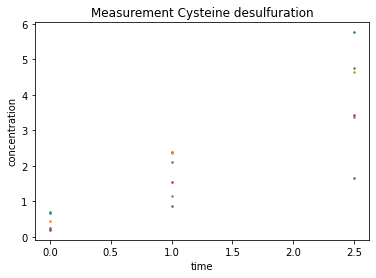

In [5]:
# plot time course data with matplotlib
reaction_name = enzmlDoc.getReaction('r0').name
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    ax.plot(time, measured_data[i, :], '.', ms=3, label='repl '+str(i+1))
plt.title('Measurement '+reaction_name)
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.savefig('time-course.svg', bbox_inches='tight')
plt.show()

## Kinetic modelling and parameter estimation <a class="anchor" name="KineticModelling"></a>
In order to model the data and perform parameter fitting, the kinetic equations for the models are defined as Python functions, along with a function to calculate the residual between the models and the measured data. Chosen for the parameter estimation is the irreversible Michaelis-Menten model. In addition, the residual is calculated.

In [6]:
def irreversible_Michaelis_Menten(w, t, params):
    '''
    Differential equation
    Arguments:
        w: vector of state variables: w = [S,P,E]
        t: time
        params: parameters object from lmfit
    '''
    
    S = w[0]
    
    vmax = params['v_max'].value
    Km = params['K_M'].value
    
    # f(S', P', E'):
    dS = -vmax*S/(Km+S)
    dP = vmax*S/(Km+S)
    
    return (dS, dP)

In [7]:
def residual(params, t, data, w, f):
    '''
    Calculates residual between measured data and modeled data

    Args:
        params: parameters object from lmfit
        t: time
        data: measured data
        f: ODEs
    '''
    try:
        bias = np.array([params['bias'].value,0,0])
        w = np.add(w, bias)
    except KeyError:
        pass
    ndata = data.shape[0]
    residual = 0.0*data[:]
    for i in range(ndata):
        model = odeint(f, w[i], t, args=(params,))
        p_model = model[:,1]
        residual[i,:]=measured_data[i,:]-p_model
    return residual.flatten()

In [8]:
colors = ['#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#f781bf']

### Initialising parameters 
The Python library lmfit provides a parameter object to initialise the parameters before the fit.

In [9]:
slopes = []
if (measured_data.shape[1]==2):
    for i in range(measured_data.shape[0]):
        slope = (measured_data[i][1]-measured_data[i][0])/(time[1]-time[0])
        slopes.append(slope)
else:
    for i in range(measured_data.shape[0]):
        slope, intercept, r, p, se = stats.linregress(time[1:], measured_data[i][1:]) # time[0:2], data[i][0:2]
        slopes.append(slope)
vmax = np.max(slopes)
km = s0_init_conc[0]

w = np.append(s0_init_conc, s1_init_conc).reshape((2, s0_init_conc.shape[0]))
w = np.transpose(w)

params = Parameters()
params.add('v_max', value=vmax, min=0.0001, max=100000)
params.add('K_M', value=km, min=0.0001, max=np.max(measured_data)*100)

### Parameter fitting and results 
In the next cell the parameters for rhe model are fitted against the measured data and the results are stored in a dictionary.
The output of the cell after that shows the results from the residual minimisation done by lmfit. Followed by a plot containing the measured data and the curve with the estimated parameters.

In [10]:
result = minimize(residual , params, args=(time, measured_data, w, irreversible_Michaelis_Menten), method='leastsq')

In [11]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 18
    # variables        = 2
    chi-square         = 0.93351125
    reduced chi-square = 0.05834445
    Akaike info crit   = -49.2651324
    Bayesian info crit = -47.4843889
[[Variables]]
    v_max:  1.91183008 +/- 0.06720050 (3.51%) (init = 2.240552)
    K_M:    7.86922481 +/- 1.33142427 (16.92%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(v_max, K_M) = 0.693


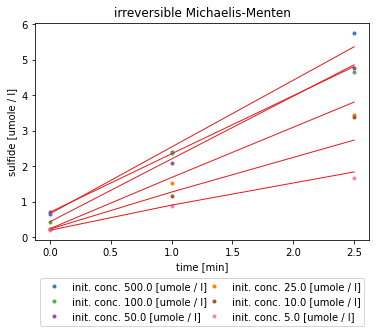

In [12]:
plt.figure()
ax = plt.subplot()
ax.clear()
for i in range(measured_data.shape[0]):
    data_fitted1 = odeint(irreversible_Michaelis_Menten, w[i], time, args=(result.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, label='init. conc. '+str(w[i][0])+' ['+conc_unit+']', color=colors[i])
    ax.plot(time, data_fitted1[:,1], '-', linewidth=1, color='#e31a1c')
plt.title('irreversible Michaelis-Menten')
xlabel = f"{'time'} [{time_unit}]"
ylabel = f"{enzmlDoc.reactant_dict['s1'].name} [{conc_unit}]"
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
plt.legend(bbox_to_anchor=(0, 0, 1, -0.15), mode="expand", ncol=2)
plt.savefig('model.svg', bbox_inches='tight')
plt.show()